In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
import random
from functions import *
import seaborn as sns

metrics_dict = {}

# Import

The data from the EDA is imported and cleaned up a bit. The classification task that will be attempted is a binary classification task (Left vs. Right classified news articles). As such, the "Middle" category explored in the EDA is replaced with "Left," as the only middle publisher (Associated Press) is slightly left-leaning, strictly speaking according to the bias scores:

In [2]:
dframe = pd.read_csv("news_dataset_EDA.csv")

dframe["Leaning"] = dframe["Leaning"].map({"Middle" : "Left",
                                           "Left": "Left",
                                           "Right": "Right"})

dframe.drop("Leaning Encode", axis=1, inplace=True)

All data is re-encoded:

In [3]:
encode = []

for i in range(dframe.shape[0]):
    lean = dframe["Leaning"].iloc[i]
    if lean == "Left":
        encode.append(0)
    elif lean == "Right":
        encode.append(1)

dframe["Leaning Encode"] = pd.Series(encode)

Examining the data to ensure the encoding was done properly:

In [4]:
dframe.head()

,Source,Headline,Content,Date,Leaning,Headline Length,Content Length,Normalized Headline,Normalized Content,LDA_topics,NMF_topics,Headline Polarity,Content Polarity,Leaning Encode
0,Associated Press,"For Nebraska Rep. Fortenberry, a two-sided cha...","LINCOLN, Neb. -- When he seeks office again i...",11/15/21,Left,9,817,nebraska rep fortenberry two sided challenge 2022,lincoln neb seek office 2022 u rep jeff forten...,House/Senate,Trump,0.000000,0.072480,0
1,Associated Press,Former New Orleans mayor Landrieu to manage Bi...,WASHINGTON -- President Joe Biden has chosen ...,11/15/21,Left,10,295,former new orleans mayor landrieu manage biden...,washington president joe biden chosen supervis...,Inflation/Infrustructure,Inflation/Infrastructure,0.068182,0.115488,0
2,Associated Press,Alzheimer's drug cited as Medicare premium jum...,"WASHINGTON -- Medicare's ""Part B"" outpatient ...",11/15/21,Left,9,739,alzheimers drug cited medicare premium jump 2160,washington medicare part b outpatient premium ...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.031020,0
3,Associated Press,Buttigieg's star rises as $1T Biden agenda shi...,"WASHINGTON -- Pete Buttigieg, the transportat...",11/15/21,Left,10,1212,buttigiegs star rise 1t biden agenda shift toward,washington pete buttigieg transportation secre...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.147375,0
4,Associated Press,Inside DNC chair's 'challenging' bid to avert ...,He's not particularly close to the White House...,11/15/21,Left,9,2019,inside dnc chair challenging bid avert midterm...,he particularly close white house he never sta...,House/Senate,Trump,0.500000,0.055720,0


Any null data are removed:

In [5]:
dframe = dframe.dropna()

In [6]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 0 to 1493
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Source               1493 non-null   object 
 1   Headline             1493 non-null   object 
 2   Content              1493 non-null   object 
 3   Date                 1493 non-null   object 
 4   Leaning              1493 non-null   object 
 5   Headline Length      1493 non-null   int64  
 6   Content Length       1493 non-null   int64  
 7   Normalized Headline  1493 non-null   object 
 8   Normalized Content   1493 non-null   object 
 9   LDA_topics           1493 non-null   object 
 10  NMF_topics           1493 non-null   object 
 11  Headline Polarity    1493 non-null   float64
 12  Content Polarity     1493 non-null   float64
 13  Leaning Encode       1493 non-null   int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 175.0+ KB


## NMF Data

In [7]:
y = dframe["Leaning Encode"].values
dframe = dframe[["Headline Length", "Content Length", "NMF_topics", "Headline Polarity", "Content Polarity"]]

In [8]:
dframe = pd.get_dummies(dframe, prefix="Topic")

In [9]:
dframe.head()

,Headline Length,Content Length,Headline Polarity,Content Polarity,Topic_Biden,Topic_Border/Migrant/Immgiration,Topic_COVID-19/Vaccine,Topic_China,Topic_House/Senate,Topic_Inflation/Infrastructure,Topic_Insurrection,Topic_Police,Topic_Trump,Topic_US Trials/Court Cases
0,9,817,0.000000,0.072480,0,0,0,0,0,0,0,0,1,0
1,10,295,0.068182,0.115488,0,0,0,0,0,1,0,0,0,0
2,9,739,0.000000,0.031020,0,0,0,0,0,1,0,0,0,0
3,10,1212,0.000000,0.147375,0,0,0,0,0,1,0,0,0,0
4,9,2019,0.500000,0.055720,0,0,0,0,0,0,0,0,1,0


In [10]:
X = dframe.values

# Machine Learning Models

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## Test/Train Split

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### k-Nearest Neighbors

In [14]:
test_prec = []
train_prec = []

for i in range(1,21):
    clf = KNeighborsClassifier(n_neighbors=i)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="precision", return_train_score=True)
    test_prec.append(np.mean(cv_results['test_score']))
    train_prec.append(np.mean(cv_results['train_score']))

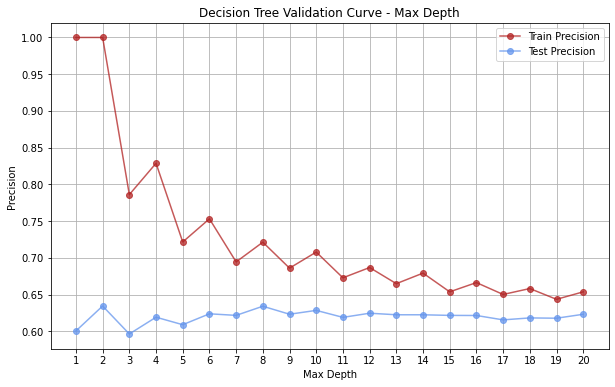

In [15]:
xs = list(range(1,21))
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, train_prec, "o-", color="firebrick", alpha=0.75, label = "Train Precision")
axes.plot(xs, test_prec, "o-", color="cornflowerblue", alpha=0.75, label = "Test Precision")
axes.set_title("Decision Tree Validation Curve - Max Depth")
axes.set_xlabel("Max Depth")
axes.set_ylabel("Precision")
axes.legend()
plt.xticks(xs)
plt.grid(b=True, which="both")
plt.show()

In [16]:
clf = KNeighborsClassifier(n_neighbors=1)
cv_results = cross_validate(clf, X, y, cv=5, scoring="accuracy")

In [17]:
np.mean(cv_results['test_score'])

0.5773360867320599

### Decision Tree

In [18]:
test_prec = []
train_prec = []

for i in range(2,21):
    clf = tree.DecisionTreeClassifier(random_state=0, max_depth=i)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="precision", return_train_score=True)
    test_prec.append(np.mean(cv_results['test_score']))
    train_prec.append(np.mean(cv_results['train_score']))

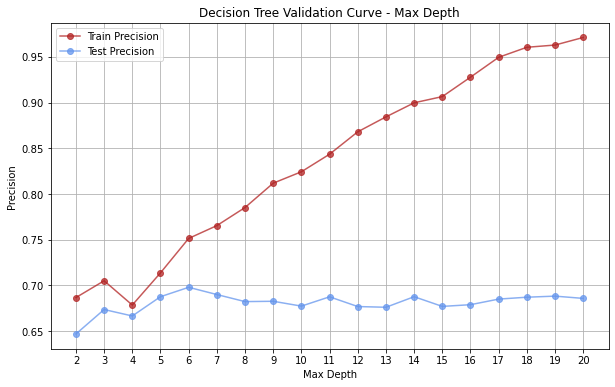

In [19]:
xs = list(range(2,21))
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, train_prec, "o-", color="firebrick", alpha=0.75, label = "Train Precision")
axes.plot(xs, test_prec, "o-", color="cornflowerblue", alpha=0.75, label = "Test Precision")
axes.set_title("Decision Tree Validation Curve - Max Depth")
axes.set_xlabel("Max Depth")
axes.set_ylabel("Precision")
axes.legend()
plt.xticks(xs)
plt.grid(b=True, which="both")
plt.show()

In [20]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
cv_results = cross_validate(clf, X, y, cv=5, scoring="accuracy")

In [21]:
np.mean(cv_results['test_score'])

0.6745437812843706

In [22]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [23]:
clf.score(X_test, y_test)

0.679144385026738

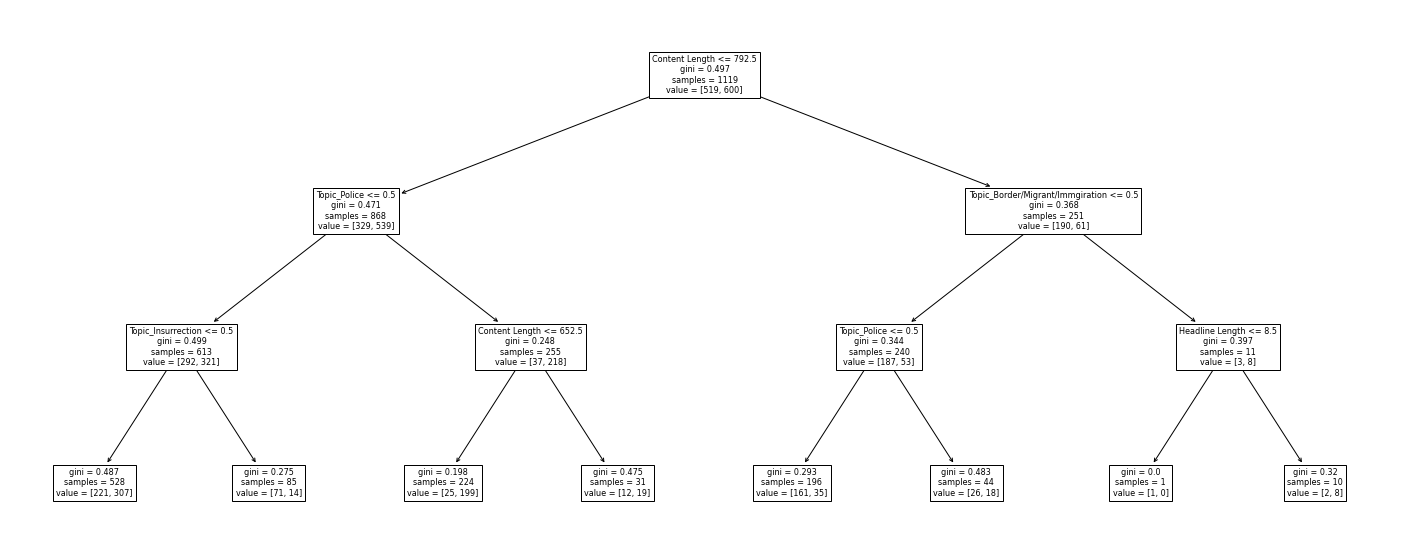

In [24]:
plt.figure(figsize=(25,10))
tree.plot_tree(clf, feature_names=dframe.columns);

### Random Forest

In [25]:
test_prec = []
train_prec = []

for i in range(2,21):
    clf = RandomForestClassifier(random_state=0, max_depth=i)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="precision", return_train_score=True)
    test_prec.append(np.mean(cv_results['test_score']))
    train_prec.append(np.mean(cv_results['train_score']))

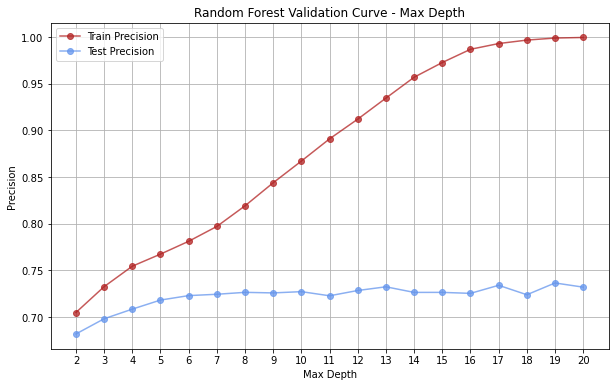

In [26]:
xs = list(range(2,21))
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, train_prec, "o-", color="firebrick", alpha=0.75, label = "Train Precision")
axes.plot(xs, test_prec, "o-", color="cornflowerblue", alpha=0.75, label = "Test Precision")
axes.set_title("Random Forest Validation Curve - Max Depth")
axes.set_xlabel("Max Depth")
axes.set_ylabel("Precision")
axes.legend()
plt.xticks(xs)
plt.grid(b=True, which="both")
plt.show()

In [29]:
clf = RandomForestClassifier(random_state=0, max_depth=8)
cv_results = cross_validate(clf, X, y, cv=5, scoring="accuracy")

In [30]:
np.mean(cv_results['test_score'])

0.7314471055644092